# Hands-On Tutorial: Automated Predictive (APL) in SAP HANA Cloud
## Apply Machine Learning Model
https://blogs.sap.com/2020/07/27/hands-on-tutorial-automated-predictive-apl-in-sap-hana-cloud/

In [1]:
import hana_ml
print(hana_ml.__version__)

2.18.23092701


### Connect to SAP HANA Cloud

In [2]:
import hana_ml.dataframe as dataframe
conn = dataframe.ConnectionContext(userkey = 'MYHC',
                                   encrypt = 'true')
conn.connection.isconnected()

True

### Prediction data

Point to the data in SAP HANA Cloud. Add a sort to ensure reproducability

In [3]:
df_remote_new = conn.table(table = 'BANKMARKETING_TOPREDICT').sort("CUSTOMER_ID", desc = False)
df_remote_new.head(5).collect()

,CUSTOMER_ID,AGE,JOB,MARITAL,EDUCATION,DEFAULT,BALANCE,HOUSING,LOAN,CONTACT,DAY,MONTH,CAMPAIGN,PDAYS,PREVIOUS,POUTCOME
0,1,40,entrepreneur,married,secondary,no,3000,yes,no,unknown,10,may,1,-1,0,unknown
1,2,65,management,single,tertiary,no,3000,no,no,telephone,10,mar,1,-1,12,success


### Load the trained model

In [4]:
from hana_ml.model_storage import ModelStorage
model_storage = ModelStorage(connection_context = conn)
gbapl_model = model_storage.load_model(name = 'Bank Marketing Model')

### Create predictions

In [5]:
gbapl_model.set_params(extra_applyout_settings =
                        {'APL/ApplyExtraMode': 'Advanced Apply Settings',
                         'APL/ApplyDecision': 'true',
                         'APL/ApplyProbability': 'true',
                         'APL/ApplyPredictedValue': 'false'
                        })
df_remote_predict = gbapl_model.predict(df_remote_new)
df_predict = df_remote_predict.head(10).collect()
df_predict.columns = [hdr.replace('gb_', '') for hdr in df_predict.columns] # shorten column names
df_predict.style.format({'proba_PURCHASE':'{0:,.3f}'}).hide(axis='index')

CUSTOMER_ID,PREDICTED,proba_PURCHASE
1,no,0.033
2,yes,0.796


### Explain the predictions

In [6]:
gbapl_model.set_params(extra_applyout_settings={'APL/ApplyExtraMode': 'Individual Contributions'})
df_remote_predict = gbapl_model.predict(df_remote_new)
df_predict = df_remote_predict.head(10).collect()
df_predict.columns = [hdr.replace("gb_", "") for hdr in df_predict.columns] # Shorten column names
df_predict

,CUSTOMER_ID,PREDICTED,score_PURCHASE,contrib_AGE,contrib_MARITAL,contrib_EDUCATION,contrib_BALANCE,contrib_HOUSING,contrib_LOAN,contrib_CONTACT,contrib_DAY,contrib_MONTH,contrib_CAMPAIGN,contrib_PREVIOUS,contrib_POUTCOME,contrib_constant_bias
0,1,no,-3.362570,-0.061166,-0.101978,-0.042685,0.249151,-0.116452,0.028893,-0.950099,0.000683,-0.260125,0.084510,-0.197137,0.053647,-2.049811
1,2,yes,1.361992,0.580599,0.058357,0.110169,0.255366,0.183404,0.044148,-0.099252,0.013740,0.792756,0.104633,0.430414,0.937468,-2.049811


Visualise the explainability for a selected prediction

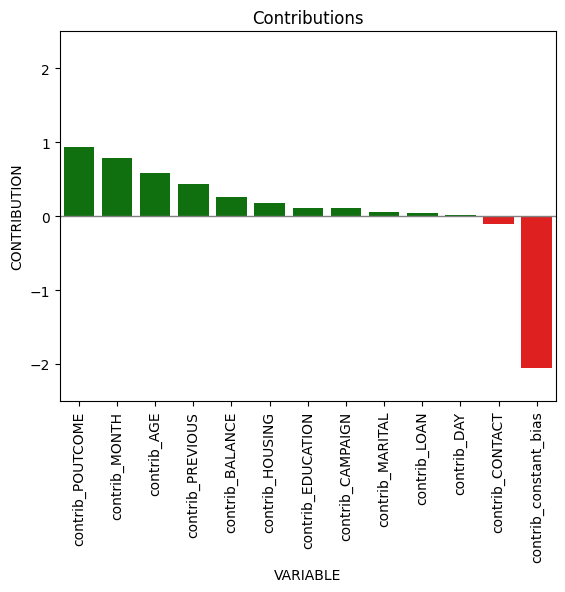

In [12]:
df_contributions_single = df_predict[df_predict['CUSTOMER_ID'] == 2]
df_contributions_single = df_contributions_single.melt(id_vars = ['CUSTOMER_ID', 'PREDICTED', 'score_PURCHASE'])
df_contributions_single.columns = ['CUSTOMER_ID', 'PREDICTED', 'SCORE', 'VARIABLE', 'CONTRIBUTION']
df_contributions_single = df_contributions_single.sort_values(by = ['CONTRIBUTION'], ascending = [False])
df_contributions_single.style.format({'CONTRIBUTION':'{0:,.3f}'}) 

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline 
plt.figure()
bar_color = np.where(df_contributions_single['CONTRIBUTION'] > 0 ,'green', 'red')
bplot = sns.barplot(data = df_contributions_single, x = 'VARIABLE', y = 'CONTRIBUTION',  palette = bar_color.tolist())
bplot.set_title('Contributions')
bplot.set_xticklabels(bplot.get_xticklabels(), rotation = 90)
plt.axhline(y = 0, color = 'grey', linewidth = 1)
plt.ylim(-2.5, 2.5);

### Save the predictions

In [8]:
df_remote_predict.save('BANKMARKETING_PREDICTED',
                       force = True)